In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys


In [10]:

df1=pd.read_csv("labeleddata.csv")

In [11]:
df1=df1.drop(columns=['Unnamed: 0'])

In [12]:
df1.head()

df=df1.copy()
df1.loc[df1['flags']=='DF','flags']=0
train_y=np.array(df['attack'].values)
train_x=df1.drop(columns=['src_ip','dst_ip','attack'])

df1['attack'].value_counts()
df1.head()
print(train_x.shape)
print(train_y.shape)

(50000, 12)
(50000,)


In [13]:
import sys
class Nn:
    def __init__(self,epochs=2500,lr=1.0,layers=[15,10,5,2]):
        self.layers=layers
        self.epochs=epochs
        self.lr=lr
        self.mns=[]
        self.bnloss=[]
        self.layer_outputs=[[] for i in range(4)]
        self.activation_outputs=[]
        self.losses=[]
        self.layer_weights=[[] for i in range(4)]
        self.layer_inputs=[]

    def init_weights(self,f_weight_size):
        ##layer 0 
        self.layer_weights[0]=np.random.rand(f_weight_size,self.layers[0])*0.01
        ##layer1
        self.layer_weights[1]=np.random.rand(self.layers[0],self.layers[1])*0.01
        ##layer2
        self.layer_weights[2]=np.random.rand(self.layers[1],self.layers[2])*0.01
        ##layer3
        self.layer_weights[3]=np.random.rand(self.layers[2],self.layers[3])*0.01
        
        
#         self.layer_weights[0]=np.random.normal(0.1,0.2,(f_weight_size,self.layers[0]))
#         for i in range(1,self.layers):
#             self.layer_weights[i]=np.random.normal(0.1,0.2,(self.layers[i-1],self.layers[i]))
        
        
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def relu(self,x):
        return np.maximum(x,0)
    def tanh(self,x):
        return np.tanh(x)
    
    def softmax(self,x):
        exp=np.exp(x-np.max(x,axis=1,keepdims=True))
        #return exp/(np.sum(exp,axis=1,keepdims=True))
        return np.exp(x)/np.sum(np.exp(x))
    
    def d_relu(self,x):
        x[x<=0]=0
        return x
    def d_tanh(self,x):
        return 1-np.tanh(x)**2
    def d_sigmoid(self,x):
        x=self.sigmoid(x)
        return x*(1-x)
    
    
    def forward(self,train_x):
        ##layer 0
        self.layer_inputs.append(train_x)
        dense=np.dot(train_x,self.layer_weights[0])
        activation=self.sigmoid(dense)
        self.activation_outputs.append(activation)
        
        ## layer 1
        self.layer_inputs.append(activation)
        #print(activation.shape)
        dense1=np.dot(activation,self.layer_weights[1])
        activation1=self.tanh(dense1)
        #print(activation1.shape)
        self.activation_outputs.append(activation1)
        
        ##layer 2
        self.layer_inputs.append(activation1)
        #print("layer2",activation1.shape)
        dense2=np.dot(activation1,self.layer_weights[2])
        #print("layer2",dense2.shape)
        activation2=self.relu(dense2)
        #print('layer 2',activation2.shape)
        self.activation_outputs.append(activation2)
        
        ##layer 3
        self.layer_inputs.append(activation2)
        #print(activation2.shape)
        dense3 =np.dot(activation2,self.layer_weights[3])
        #print(dense3.shape)
        activation3=self.softmax(dense3)
        #print(activation3.shape)
        self.activation_outputs.append(activation3)
        #print(activation3)
        
        return activation3
        
    def loss(self,output,y_true):
        #print(output)
        output=np.clip(output,1e-7,1e+7)
        confidences=output[range(output.shape[0]),y_true]
        #print(confidences,output,y_true)

        
#         negative_loglikelihoods= -np.log(confidences)
#         loss=np.mean(negative_loglikelihoods)
#         self.mns.append(np.mean((np.max(output,axis=1)-y_true)**2))
#         self.losses.append(loss)
        
        lossbn=0.0
        
        for i in range(output.shape[0]):
            lossbn+=y_true[i]*np.log(confidences[i])+(1-y_true[i])*np.log(1-confidences[i])
        self.bnloss.append(-1*lossbn/output.shape[0])
        #print(-1*lossbn/20)
        
        return -1*lossbn/output.shape[0]
    def cal_acc(self,output,y_true):
        acc=np.mean(np.argmax(output,axis=1)==y_true)
        return acc
    def backward(self,output,y_true):
        
        output[range(output.shape[0]),y_true] -=1
        output=output/output.shape[0]
        
        dw3=np.dot(self.layer_inputs[3].T,output)
        
        dw3_error=np.dot(output,self.layer_weights[3].T)
        dw3_error=self.d_relu(dw3_error)
        
        #print(dw3_error.shape)
        #print(np.dot(self.layer_inputs[3].T,output).shape)
        #print(self.layer_inputs[3].shape)
        
        
        dw2=np.dot(self.layer_inputs[2].T,dw3_error)
        dw2_error=np.dot(dw3_error,self.layer_weights[2].T)
        dw2_error=self.d_tanh(dw2_error)
        
        dw1=np.dot(self.layer_inputs[1].T,dw2_error)
        dw1_error=np.dot(dw2_error,self.layer_weights[1].T)
        dw1_error=self.d_sigmoid(dw1_error)
        
        dw0=np.dot(self.layer_inputs[0].T,dw1_error)
        
        
        grads=(dw0,dw1,dw2,dw3)
        return grads
    def optimize(self,grads,lr,decay=0):
        self.learning_rate=lr
        self.decay=decay
        self.c_learning_rate=lr
        self.iterations=0
        
        if self.decay:
            self.c_learning_rate=self.learning_rate*(1./(1+self.decay*self.iterations))
        for i,dw in enumerate(grads):
            self.layer_weights[i] += -self.c_learning_rate*dw
        self.iterations +=1
        
    def fit(self,train_x,train_y,batch_size):
        print(train_x.shape)
        
        self.init_weights(train_x.shape[1])
        batch_data=[]
        y_true=[]
        acc=None
        loss=None
        
        
        #train_y=train_y.reshape(-1,1)
        
        for i in range(train_x.shape[0]):
            if (i%batch_size) ==0:
                
                batch_data.append(train_x[i:i+batch_size,:])
                y_true.append(train_y[i:i+batch_size])  


        for epoch in range(self.epochs):
            output=self.forward(batch_data[epoch])
            loss=self.loss(output,y_true[epoch])
            acc=self.cal_acc(output,y_true[epoch])
            grads=self.backward(output,y_true[epoch])
            self.optimize(grads,self.lr,decay=1e-8)
            if epoch%101==0:
                print("epoch",epoch," loss: ",loss," acc: ",acc)
        self.plot_loss()
    def predict(self,test_x,test_y):
        batch_data=[]
        y_true=[]
        outputs=[]
        for i in range(test_x.shape[0]):
            if (i%20)==0:
                batch_data.append(test_x[i:i+20,:])
                y_true.append(test_y[i:i+20])
        for j in range(len(batch_data)):
            output=self.forward(batch_data[j])
            outputs.append(np.argmax(output,axis=1))
        preds=[]
        pred=np.array(20,1)
        for out in outputs:
            pred=np.stack(pred,out)
        
    
    def plot_loss(self):
        #plt.plot(self.losses)
        
        #plt.show()
        
        #plt.plot(self.mns)
        #plt.show()
        
        plt.plot(self.bnloss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Gradient Descent')
        plt.show()

(50000, 12)
(50000, 12)
(30000, 12)
epoch 0  loss:  2.040288611687695  acc:  0.45
epoch 101  loss:  1.6739205487426307  acc:  0.55
epoch 202  loss:  0.5748520549037371  acc:  0.85
epoch 303  loss:  0.3916739725972543  acc:  0.9
epoch

d:\python3.6\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


 404  loss:  0.7580301372102191  acc:  0.8
epoch 505  loss:  0.2084958902907721  acc:  0.95
epoch 606  loss:  1.3075643841296665  acc:  0.65
epoch 707  loss:  2.040276713355596  acc:  0.45
epoch 808  loss:  0.9412082195167016  acc:  0.75
epoch 909  loss:  0.3916739725972544  acc:  0.9


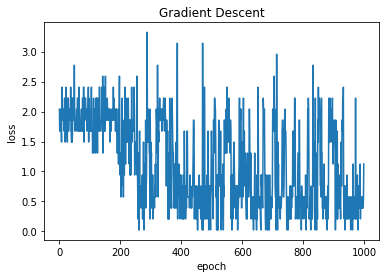

(20000, 12)
epoch 0  loss:  0.3916757083356534  acc:  0.9
epoch 101  loss:  2.40663287796856  acc:  0.35
epoch 202  loss:  1.3075643841296665  acc:  0.65
epoch 303  loss:  1.3075643841296665  acc:  0.65
epoch 404  loss:  0.5748520549037368  acc:  0.85
epoch 505  loss:  1.8570986310491133  acc:  0.5
epoch 606  loss:  0.2084958902907721  acc:  0.95
epoch 707  loss:  0.39167397259725445  acc:  0.9
epoch 808  loss:  0.9412082195167016  acc:  0.75
epoch 909  loss:  0.9412082195167015  acc:  0.75


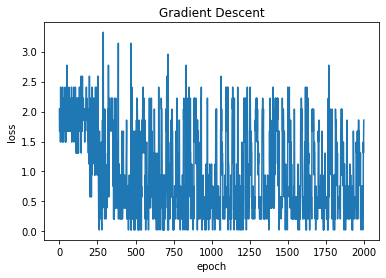

In [14]:
import sys
import numpy as np
model=Nn(epochs=1000)
#print(train_y.shape)
train_x=np.array(train_x)
print(train_x.shape)

trainx=train_x.astype("float")
trainy=train_y.astype("int")

test_x=trainx[30000:50000,:]
train_x=trainx[:30000,:]
print(trainx.shape)
test_y=trainy[30000:50000]
train_y=trainy[:30000]

model.fit(train_x,train_y,20)

model.fit(test_x,test_y,20)